In [2]:
# ignore non material warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticke
from pandas.tseries.offsets import MonthEnd

In [4]:
recession_indicator = pd.read_excel('Recession_Indicator_NBER.xlsx').set_index('DATE')

In [5]:
# interpolating the recession indicator to daily frequency
recession_indicator = recession_indicator.asfreq("D", method="ffill")

### Daily Returns

In [6]:
# Returns calculated from the futures rolling strategy
returns_daily = pd.read_csv('Final_Returns_Data.csv', index_col=0, parse_dates=True)

In [7]:
returns_daily["FTSE/Athens Notional Return"].idxmax(), returns_daily["FTSE/Athens Notional Return"].max()

(Timestamp('2016-06-21 00:00:00'), 9.471337579617837)

The index price surged 9x overnight following the decision to restructure short-term debt and grant Greece a €10 billion bailout.

In order not to skew our time series, we have decided to use exrapolated value. Linerar spline calculated as average of the day prior and following 9x return.

In [8]:
# Simple linear interpolation
idx = returns_daily["FTSE/Athens Notional Return"].idxmax()
pos = returns_daily.index.get_loc(idx)
prior_date = returns_daily.index[pos - 1]
returns_daily.loc[prior_date]
following_date = returns_daily.index[pos + 1]

# Add the average of the two surrounding values
returns_daily["FTSE/Athens Notional Return"].loc[returns_daily["FTSE/Athens Notional Return"].idxmax()] = (returns_daily["FTSE/Athens Notional Return"].loc[following_date] + returns_daily["FTSE/Athens Notional Return"].loc[prior_date]) / 2

In [9]:
#Check the new value
returns_daily["FTSE/Athens Notional Return"].loc[idx]

0.0067670316301703

### Monthly Returns

In [10]:
notional = pd.read_csv('Final_Notional_Data.csv', index_col=0, parse_dates=True)
# Step 1: Create a DataFrame of month-ends
month_ends = pd.date_range(start=notional.index.min(), end=notional.index.max(), freq='M')

# Step 2: For each month-end, find the closest date in df.index
closest_dates = []
for month_end in month_ends:
    closest_date = notional.index[np.abs((notional.index - month_end).days).argmin()]
    closest_dates.append(closest_date)

# Step 3: Extract rows at those closest dates
df_closest_to_month_end = notional.loc[sorted(set(closest_dates))]

returns_monthly = df_closest_to_month_end.pct_change().dropna()

# Deal with Athens
# Simple linear interpolation
idx = returns_monthly["FTSE/Athens Notional Value"].idxmax()
pos = returns_monthly.index.get_loc(idx)
prior_date = returns_monthly.index[pos - 1]
returns_monthly.loc[prior_date]
following_date = returns_monthly.index[pos + 1]

# Add the average of the two surrounding values
returns_monthly["FTSE/Athens Notional Value"].loc[returns_monthly["FTSE/Athens Notional Value"].idxmax()] = (returns_monthly["FTSE/Athens Notional Value"].loc[following_date] + returns_monthly["FTSE/Athens Notional Value"].loc[prior_date]) / 2

returns_monthly.describe()

,DAX Notional Value,Amsterdam Index Notional Value,CAC40 Notional Value,PSI-20 Notional Value,IBEX-35 Notional Value,FTSE/Athens Notional Value,BEL-20 Notional Value,FTSE/MIB Notional Value,Gold Notional Value,Silver Notional Value
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,0.007121,0.006591,0.005938,0.002680,0.005943,0.001997,0.005134,0.005139,0.009129,0.010669
std,0.051665,0.047431,0.047944,0.050424,0.054821,0.091698,0.048334,0.058607,0.047736,0.092569
min,-0.173032,-0.199692,-0.168957,-0.202864,-0.215921,-0.305530,-0.208714,-0.217006,-0.180050,-0.279791
25%,-0.023088,-0.019074,-0.023549,-0.024552,-0.022831,-0.047848,-0.020714,-0.027160,-0.020996,-0.054097
50%,0.013294,0.012669,0.009803,0.005193,0.007164,0.008565,0.013739,0.009324,0.005240,0.000986
75%,0.037859,0.035262,0.036580,0.030809,0.035203,0.058153,0.034870,0.040573,0.039517,0.066292
max,0.169795,0.138109,0.202521,0.167766,0.258393,0.315495,0.210823,0.232054,0.140449,0.304222


# Descriptive Data Analysis

Key statistics on our returns data.

In [11]:
returns_daily.describe().round(4).map(lambda x: f'{x*100:.2f}%').drop("count")

,DAX Notional Return,Amsterdam Index Notional Return,CAC40 Notional Return,PSI-20 Notional Return,IBEX-35 Notional Return,FTSE/Athens Notional Return,BEL-20 Notional Return,FTSE/MIB Notional Return,Gold Notional Return,Silver Notional Return
mean,0.03%,0.03%,0.03%,0.01%,0.03%,0.00%,0.03%,0.02%,0.04%,0.05%
std,1.28%,1.21%,1.29%,1.19%,1.36%,2.07%,1.46%,1.42%,1.08%,2.02%
min,-11.09%,-11.29%,-12.38%,-9.75%,-13.13%,-20.08%,-27.47%,-15.55%,-9.35%,-17.75%
25%,-0.52%,-0.48%,-0.55%,-0.55%,-0.60%,-0.82%,-0.51%,-0.60%,-0.45%,-0.85%
50%,0.05%,0.06%,0.04%,0.04%,0.04%,0.00%,0.04%,0.05%,0.02%,0.02%
75%,0.65%,0.61%,0.65%,0.62%,0.68%,0.86%,0.61%,0.72%,0.60%,1.03%
max,12.84%,11.78%,10.76%,12.53%,14.78%,26.75%,38.48%,10.76%,9.03%,12.97%


# Visualization

## Quantile Analysis

In [12]:
def analyze_by_prev_month_volatility(daily_returns_df, column):

    """
    Segregates months by previous month's realized volatility and computes:
        - average daily return
        - daily return variance
    for each month.
    """
    
    endofmonth=daily_returns_df.index+MonthEnd(0)

    # Step 1: Calculate monthly realized volatility (variance of daily returns)
    monthly_vol = daily_returns_df[column].groupby(endofmonth).var()

    # Step 2: Shift to get the previous month's volatility
    prev_month_vol = monthly_vol.shift(1)

    # Step 3: Ensure proper alignment for daily data
    prev_vol_per_day = prev_month_vol.loc[endofmonth].values

    # Step 4: Prepare the DataFrame with the necessary columns
    df = pd.DataFrame({
        'daily_return': daily_returns_df[column],
        'prev_month_vol': prev_vol_per_day, 
        'endofmonth': endofmonth,
        'month': endofmonth
    })

    # Step 5: Group by month and calculate average daily return and variance
    grouped = df.groupby('month').agg({
        'daily_return': ['mean', 'var'],
        'prev_month_vol': 'first'  # Use first value as all rows in the month share the same volatility
    })

    # Step 6: Flatten MultiIndex columns
    grouped.columns = ['avg_daily_return', 'daily_return_var', 'prev_month_vol']

    # Step 7: Sort by previous month's volatility in descending order
    result_df = grouped.sort_values('prev_month_vol', ascending=False)
    
    return result_df

In [13]:
#Segregates months by previous month's realized volatility
dax_prev_month_vol = analyze_by_prev_month_volatility(returns_daily, "DAX Notional Return")
cac40_prev_month_vol = analyze_by_prev_month_volatility(returns_daily, "CAC40 Notional Return")
ftse_prev_month_vol = analyze_by_prev_month_volatility(returns_daily, "FTSE/Athens Notional Return")
psi_20_prev_month_vol = analyze_by_prev_month_volatility(returns_daily, "PSI-20 Notional Return")
ibex35_prev_month_vol = analyze_by_prev_month_volatility(returns_daily, "IBEX-35 Notional Return")
ftse_mib_prev_month_vol = analyze_by_prev_month_volatility(returns_daily, "FTSE/MIB Notional Return")
amsterdam_prev_month_vol = analyze_by_prev_month_volatility(returns_daily, 'Amsterdam Index Notional Return')
bel20_prev_month_vol = analyze_by_prev_month_volatility(returns_daily, 'BEL-20 Notional Return')
gold_prev_month_vol = analyze_by_prev_month_volatility(returns_daily, 'Gold Notional Return')
silver_prev_month_vol = analyze_by_prev_month_volatility(returns_daily, 'Silver Notional Return')

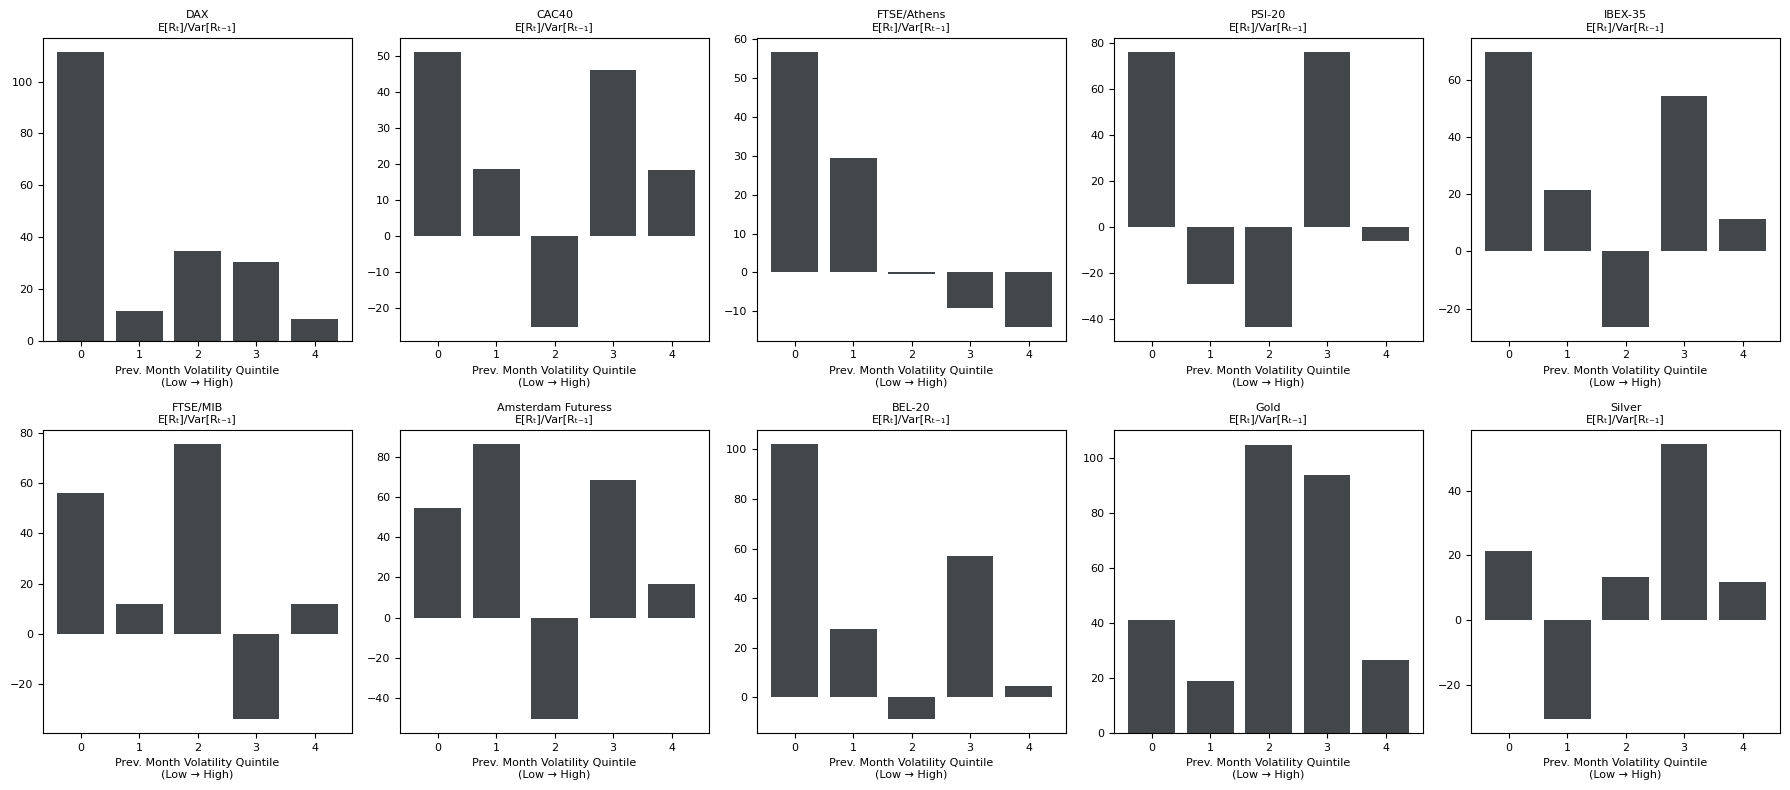

In [61]:
# Similar to Figure 1 Moeira and Muir (2017) 
data_dict = {
    "DAX": dax_prev_month_vol,
    "CAC40": cac40_prev_month_vol,
    "FTSE/Athens": ftse_prev_month_vol,
    "PSI-20": psi_20_prev_month_vol,
    "IBEX-35": ibex35_prev_month_vol,
    "FTSE/MIB": ftse_mib_prev_month_vol,
    "Amsterdam Futuress": amsterdam_prev_month_vol,
    "BEL-20": bel20_prev_month_vol,
    "Gold": gold_prev_month_vol,
    "Silver": silver_prev_month_vol
}

#Create grid of plots
fig, axes = plt.subplots(2,5, figsize=(18,8))
axes = axes.flatten()

for idx, (label, result_df) in enumerate(data_dict.items()):

    # Create volatility quintiles
    result_df['vol_quintile'] = pd.qcut(result_df['prev_month_vol'], q=5, labels=False)

    # Group by quintile and compute summary stats
    summary = result_df.groupby('vol_quintile').agg({
        'avg_daily_return': 'mean',
        'daily_return_var': 'mean'
    })

    summary['return_to_var'] = summary['avg_daily_return'] / summary['daily_return_var']

    # Plot Return-to-Volatility (Annualized)
    ax = axes[idx]
    ax.bar(summary.index, summary['return_to_var']*np.sqrt(252), color="#43474a")
    ax.set_title(f"{label}\nE[Rₜ]/Var[Rₜ₋₁]", fontsize=8)
    ax.set_xlabel('Prev. Month Volatility Quintile\n(Low → High)', fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

## Cummulative Rerturns and Realized Volatility

In [34]:
returns_daily_w_recession = returns_daily.merge(recession_indicator, left_index=True, right_index=True, how='left').fillna(method="ffill").dropna()
returns_daily_w_recession.columns

Index(['DAX Notional Return', 'Amsterdam Index Notional Return',
       'CAC40 Notional Return', 'PSI-20 Notional Return',
       'IBEX-35 Notional Return', 'FTSE/Athens Notional Return',
       'BEL-20 Notional Return', 'FTSE/MIB Notional Return',
       'Gold Notional Return', 'Silver Notional Return', 'NBER_INDEX'],
      dtype='object')

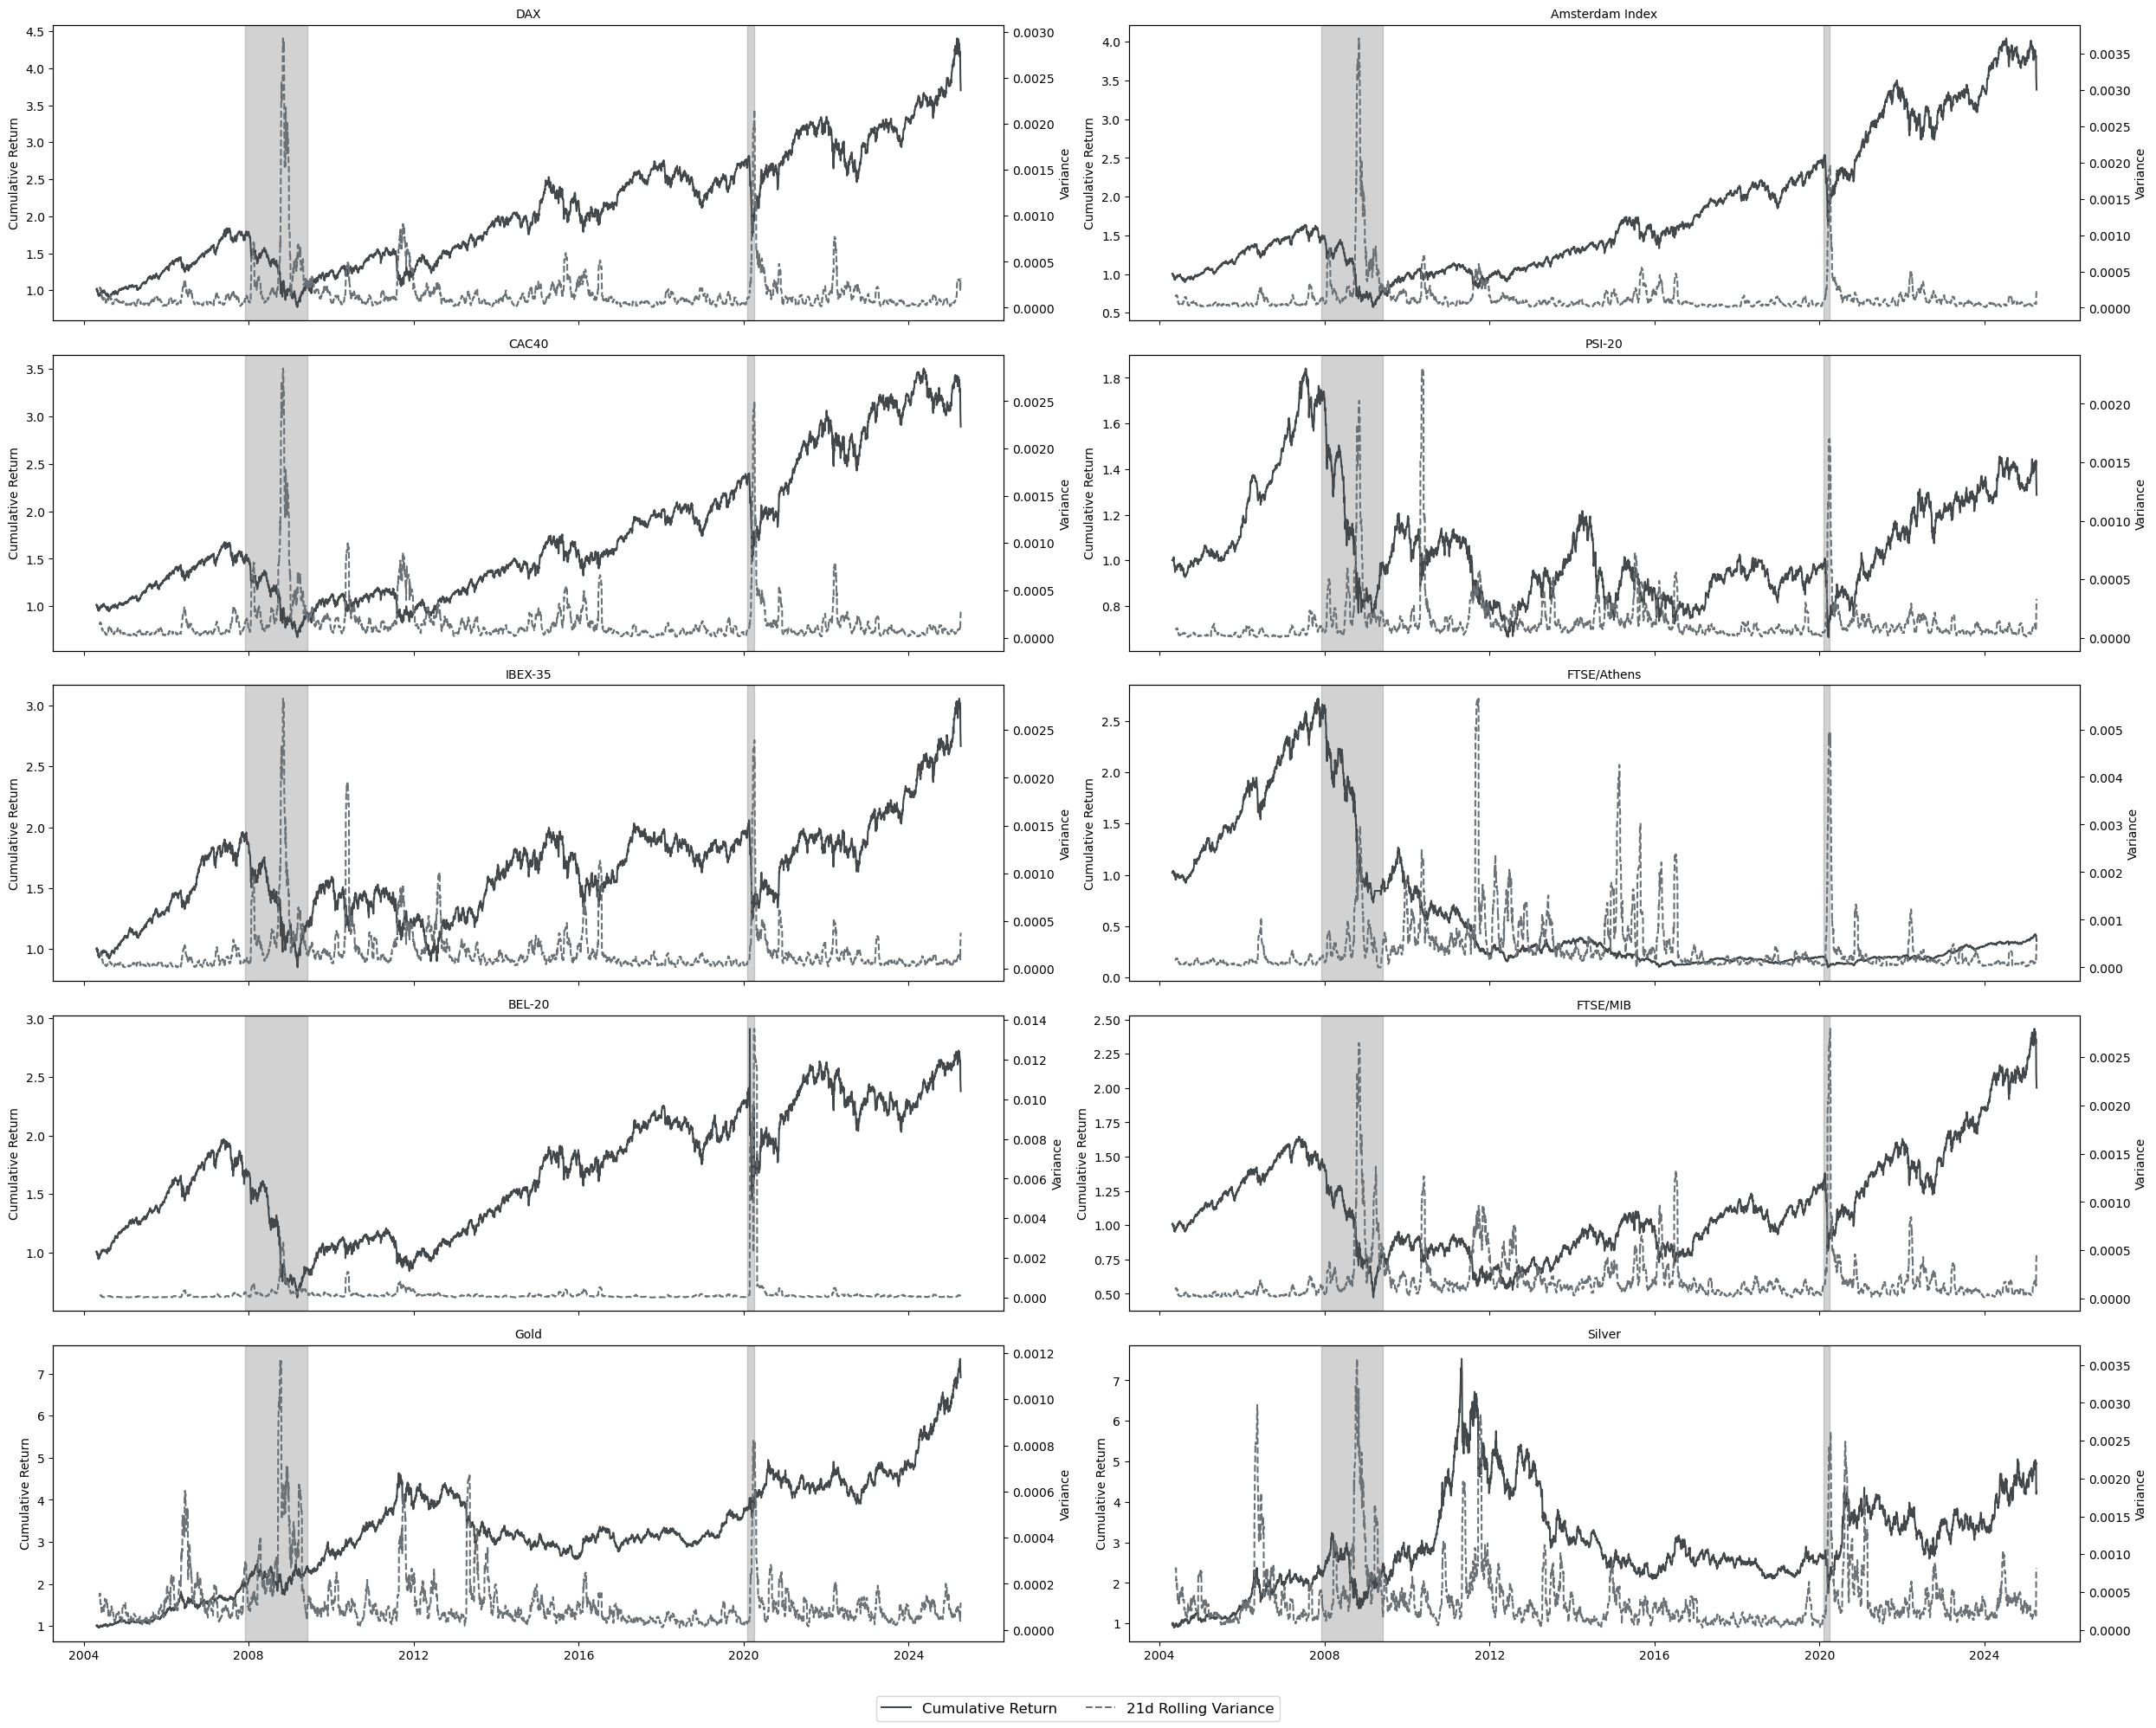

In [ ]:
columns = [
    'DAX Notional Return', 'Amsterdam Index Notional Return',
    'CAC40 Notional Return', 'PSI-20 Notional Return',
    'IBEX-35 Notional Return', 'FTSE/Athens Notional Return',
    'BEL-20 Notional Return', 'FTSE/MIB Notional Return',
    'Gold Notional Return', 'Silver Notional Return'
]

# Recession shading logic
recession_periods = returns_daily_w_recession["NBER_INDEX"].diff().fillna(0)
recession_starts = returns_daily_w_recession.index[(recession_periods == 1)]
recession_ends = returns_daily_w_recession.index[(recession_periods == -1)]
if len(recession_starts) > len(recession_ends):
    recession_ends = recession_ends.append(pd.Index([returns_daily_w_recession.index[-1]]))

# Set up the grid
fig, axs = plt.subplots(5, 2, figsize=(25, 20), sharex=True)
axs = axs.flatten()

# For collecting legend handles
cumulative_handles = []
volatility_handles = []

for i, col in enumerate(columns):
    ax1 = axs[i]
    ax2 = ax1.twinx()

    # Cumulative return line
    cum_line, = ax1.plot((1 + returns_daily_w_recession[col]).cumprod(), color="#43474a", label="Cumulative Return")
    ax1.set_ylabel("Cumulative Return", color='black')
    ax1.tick_params(axis='y', labelcolor="black")

    # Rolling variance line
    vol_line, = ax2.plot(returns_daily_w_recession[col].rolling(window=21).var(), color="#6c7175", linestyle="--", label="21d Rolling Variance")
    ax2.set_ylabel("Variance", color="black")
    ax2.tick_params(axis='y', labelcolor="black")

    # Shading for recessions
    for start, end in zip(recession_starts, recession_ends):
        ax1.axvspan(start, end, color='gray', alpha=0.35)

    ax1.set_title(col.replace(" Notional Return", ""), fontsize=10)

    # Only add handles once (first iteration)
    if i == 0:
        cumulative_handles.append(cum_line)
        volatility_handles.append(vol_line)

# Add shared legend at bottom center
fig.legend(
    cumulative_handles + volatility_handles,
    ["Cumulative Return", "21d Rolling Variance"],
    loc="lower center",
    ncol=2,
    fontsize=12
)

plt.tight_layout(rect=[0, 0.03, 1, 1])  
plt.show()

In [17]:
#Calulate monthly realized volatility based on daily returns

# Step 1: Convert daily returns index to period (monthly)
returns_daily_period = returns_daily.copy()
returns_daily_period.index = returns_daily_period.index.to_period('M')

# Step 2: Calculate monthly variance (variance of daily returns in each month)
monthly_vol = returns_daily_period.groupby(returns_daily_period.index).std()

# Step 3: Convert returns_monthly index to period as well
returns_monthly_period = returns_monthly.copy()
returns_monthly_period.index = returns_monthly.index.to_period('M')

# Step 4: Align monthly variance with monthly returns
aligned_vol = monthly_vol.reindex(returns_monthly_period.index)

aligned_vol.index = returns_monthly.index